In [5]:
%load_ext autoreload

%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from utils import _DeepLiftShap, _GradCAMPlusPlus
from data import PascalVOC2007
from results.results_metrics import ResultMetrics
from utils import (
    cut_model_from_layer,
    cut_model_to_layer,
)
from models import vgg11_PascalVOC

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
torch.manual_seed(123)
np.random.seed(123)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Here the VGG-11 model is instantiated, the last layer is replaced with a new layer that has 20 outputs instead of 1000 (because PascalVOC has 20 classes, but the model was trained on ImageNet which has 1000 classes). The loaded weights are pretrained on ImageNet and the fine-tuned on PascalVOC. For more detail about the fine-tuning process, see `fine_tuning.py`.

In [6]:
model = vgg11_PascalVOC()
model.to(device)
# Load the pretrained weights
model.load_state_dict(torch.load('VGG11_PascalVOC.pt', map_location=device))
model.eval()

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                 # Convert to Tensor
    transforms.Normalize(                  # Normalize using ImageNet mean and std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])


In [7]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [8]:
test_data = PascalVOC2007("test", transform=preprocess)
train_data = PascalVOC2007("trainval", transform=preprocess)

Using downloaded and verified file: data\VOCtest_06-Nov-2007.tar
Extracting data\VOCtest_06-Nov-2007.tar to data
Using downloaded and verified file: data\VOCtrainval_06-Nov-2007.tar
Extracting data\VOCtrainval_06-Nov-2007.tar to data


The train data is only used in the case of DeepLiftSHAP, because it requires a baseline distribution.

In [9]:
import torch.utils
from torch.utils.data import Subset

BATCH_SIZE_TEST = 2
NUM_TEST = 4

BATCH_SIZE_TRAIN = 2
NUM_TRAIN = 8

dl_test = DataLoader(Subset(test_data, torch.randperm(len(test_data))[:NUM_TEST]), batch_size=BATCH_SIZE_TEST, shuffle=True)
dl_train = DataLoader(Subset(train_data, torch.randperm(len(train_data))[:NUM_TRAIN]), batch_size=BATCH_SIZE_TRAIN, shuffle=True)

The sum of all the attributions is equal to the difference between the output of the model on the current input, minus the average output of the model on the baseline distribution.

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1             [224, 224]        0.5        1.0             3.0 
        2             [224, 224]        0.5        1.0             3.0 
        3             [112, 112]        1.0        2.0             4.0 
        4             [112, 112]        1.0        2.0             8.0 
        5             [112, 112]        1.0        2.0             8.0 
        6               [56, 56]        2.0        4.0            10.0 
        7               [56, 56]        2.0        4.0            18.0 
        8               [56, 56]        2.0        4.0            18.0 
        9               [56, 56]        2.0        4.0            26.0 
        10              [56, 56]        2.0        4.0            26.0 
        11              [28, 28]        4.0        8.0   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1253.7097, grad_fn=<SumBackward0>)
tensor([ 3.5628, -7.7149,  8.1715])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1571.9705, grad_fn=<SumBackward0>)
tensor([ 3.5628, -7.7149,  8.1715])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(62.7365, grad_fn=<SumBackward0>)
tensor([ 3.1313, -1.9438,  4.6986])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(15.3892, grad_fn=<SumBackward0>)
tensor([ 1.4901e-06,  0.0000e+00, -9.5367e-07])


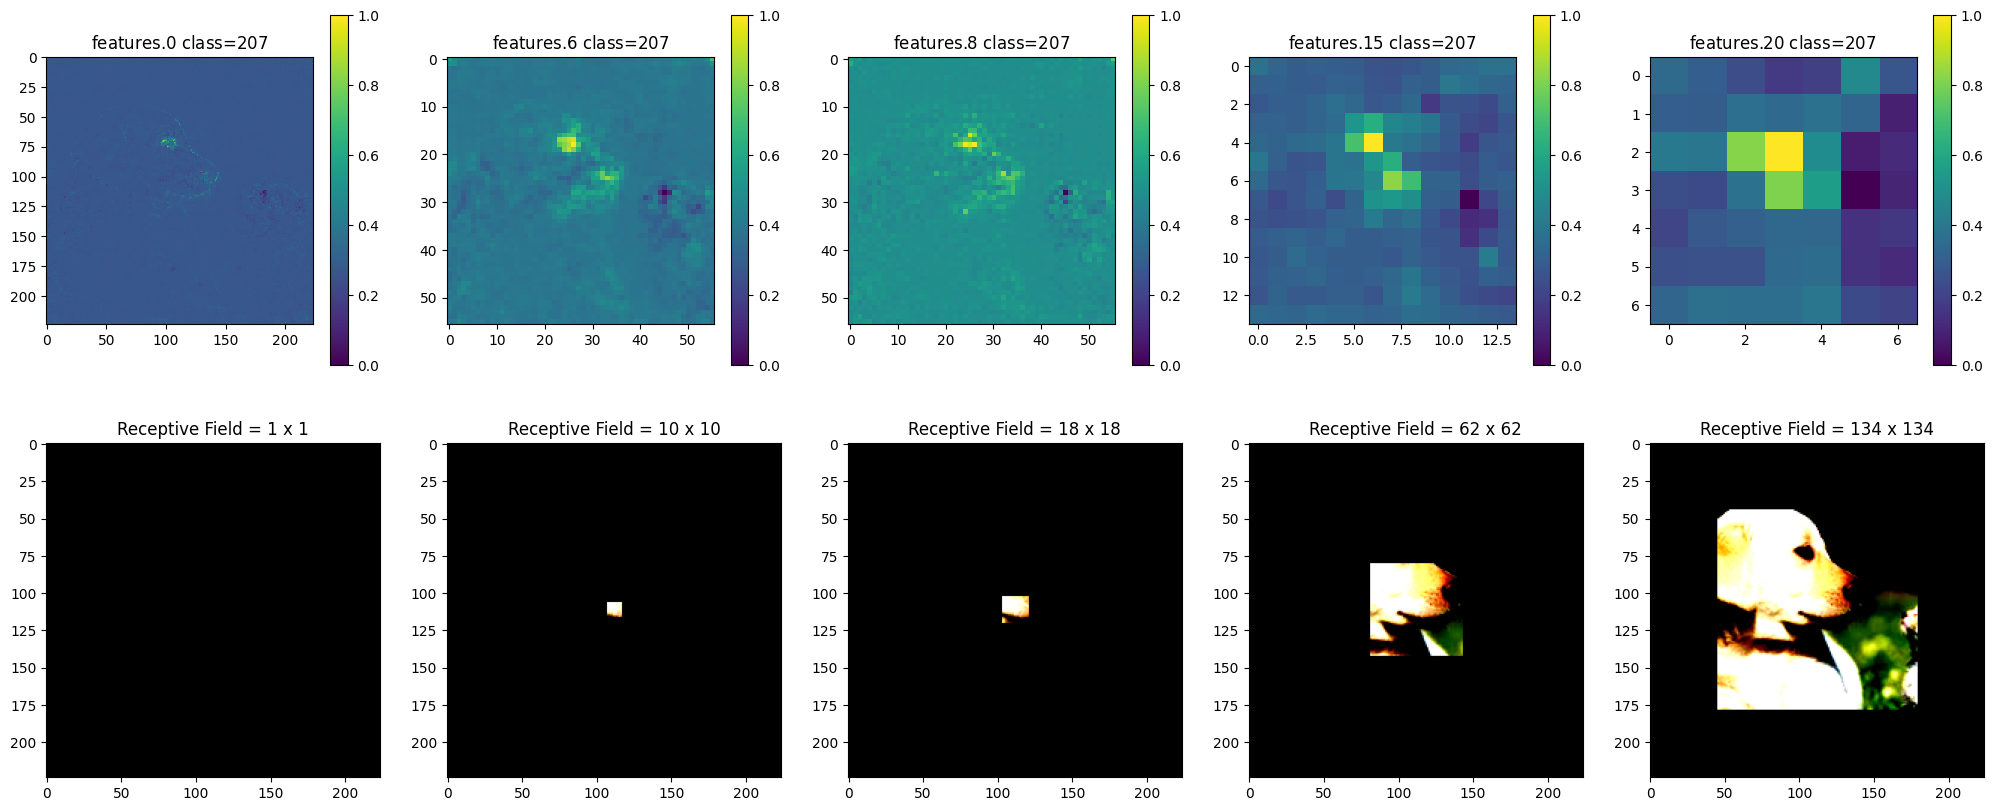

In [ ]:

receptive_field_dict = receptive_field(cut_model_to_layer(model, "classifier.0", included=False), input_size=(3, 224, 224))

target = 207
layers = ["features.0","features.6", "features.8", "features.15", "features.20"]
plt.figure(figsize=(len(layers) * 5, 10))
# fix layout
# plt.subplots_adjust(wspace=0.5, hspace=0.5)
for index, layer in enumerate(layers):
    # plt.subplot(2, len(layers)//2 + 1,index+1)
    plt.subplot(2, len(layers), index+1)
    attributions, delta = calculate_attribution(model,
                                                input_tensor,
                                                layer,
                                                target=target,
                                                baseline_dist=baseline_dist)
    attributions = attributions.sum(dim=1, keepdim=False)
    attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())

    plot_attributions(attributions, f"{layer} class=${target}$", show=False)
    print(attributions.sum())
    # Normalize the attributions between 0 and 1
    print(delta)
    
    plt.subplot(2, len(layers), index+1 + len(layers))
    # Plot the receptive field
    rf = receptive_field_dict[layer.split(".")[1]]
    rf_size = int(rf["r"])
    # Crop the image at the center with a rf_size x rf_size
    black_background = torch.zeros_like(input_tensor)
    image_center = input_tensor.shape[-1] // 2
    left = image_center - rf_size // 2
    right = image_center + rf_size // 2
    black_background[:,:,left:right,left:right] = input_tensor[:,:,left:right,left:right]
    plt.imshow(black_background.squeeze(0).permute(1,2,0).detach().numpy())
    plt.title(f"Receptive Field = {rf_size} x {rf_size}")    

In [8]:
from torch_receptive_field import receptive_field, receptive_field_for_unit

# Cut the model before the adaptive average pooling layer
model1 = cut_model_to_layer(model, "classifier.0", included=False)
model2 = cut_model_from_layer(model, "classifier.0", included=True)

d = receptive_field(model1, input_size=(3,224, 224))
r = receptive_field_for_unit(d, "10", (1,1))

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1             [224, 224]        0.5        1.0             3.0 
        2             [224, 224]        0.5        1.0             3.0 
        3             [112, 112]        1.0        2.0             4.0 
        4             [112, 112]        1.0        2.0             8.0 
        5             [112, 112]        1.0        2.0             8.0 
        6               [56, 56]        2.0        4.0            10.0 
        7               [56, 56]        2.0        4.0            18.0 
        8               [56, 56]        2.0        4.0            18.0 
        9               [56, 56]        2.0        4.0            26.0 
        10              [56, 56]        2.0        4.0            26.0 
        11              [28, 28]        4.0        8.0   

- The parameter `attribution_method` is an object that extends the base class `AttributionMethod` and implements the method `attribute`. In this way, simply changing the object passed to the `explain` method, we can change the attribution method used.
- The parameter `train_dl` is only used by the DeepLiftSHAP method, because it requires a baseline distribution.
- The function automatically add the metrics to the `ResultMetrics` object passed as parameter.
- The boolean `rescale_saliency` is used to rescale the saliency map in such a way that the integral of the saliency map is equal to $r \times (H \times W)$, where $H$ and $W$ are the height and width of the saliency map, and $r \in [0, 1]$ is the rescale factor.
    - This is useful to compare different saliency maps methods, because, for example, producing a saliency map with all ones is not useful, but gives the best results for some of the metrics.
    - The scaling is done in such a way that the positions and the values where the saliency map is equal to one are not changed. More formally, given the saliency map $S(i, j): \mathbb{R}^2 \rightarrow [0,1]$, the rescaled saliency map $S'(i, j) = S(i,j)^{\alpha^2}$ is found as an optimization problem by defining:

    $$L(S(i,j), \alpha) = \left( \int S(i,j)^{\alpha^2}  \, di \, dj  - (r \times H \times W) \right)^2$$

    $$\alpha = \arg \min_{\alpha \in \mathbb{R}} L(S(i,j), \alpha)$$

    - It can be seen as a way to constraint the saliency map into keeping only a limited amount of important pixels.

In [15]:
from metrics import calculate_metrics

RESULT_PATH = "./results.json"

results = ResultMetrics(RESULT_PATH)
calculate_metrics(model,
                _DeepLiftShap(),
                dl_test,
                dl_train,
                layers=[model.features[6], model.features[16]],
                result_metrics=results,
                device=device,
                upsample="bilinear",
                rescale_saliency=False,
                model_name="VGG11",
                )

Results file not found. Creating new results file ./results.json.


  0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\Luca\AppData\Local\Programs\Python\Python310\lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

{'features.6': {'avg_drop': 37.61792755126953,
  'increase': 25.0,
  'insertion_curve_AUC': 0.934260368347168,
  'deletion_curve_AUC': 0.14372184872627258},
 'features.16': {'avg_drop': 0.22569377720355988,
  'increase': 50.0,
  'insertion_curve_AUC': 0.9325712323188782,
  'deletion_curve_AUC': 0.2645842432975769}}

In [16]:
calculate_metrics(model,
                _GradCAMPlusPlus(),
                dl_test,
                dl_train,
                layers=[model.features[6], model.features[16]],
                result_metrics=results,
                device=device,
                upsample="bilinear",
                rescale_saliency=False,
                model_name="VGG11",
                )

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'features.6': {'avg_drop': 57.404571533203125,
  'increase': 0.0,
  'insertion_curve_AUC': 0.8091493844985962,
  'deletion_curve_AUC': 0.26245948672294617},
 'features.16': {'avg_drop': 17.490432739257812,
  'increase': 25.0,
  'insertion_curve_AUC': 0.9115763306617737,
  'deletion_curve_AUC': 0.3255438208580017}}